<a href="https://colab.research.google.com/github/TheBlackRus/liveproject_HumanPoseEstimation/blob/master/liveproject_humanpose_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 01 Download the data

In [15]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat



--2020-04-26 14:38:30--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  39.5MB/s    in 5.6s    

2020-04-26 14:38:36 (30.9 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2020-04-26 14:38:37--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  21.4MB/s    in 2.9s    

2020-04-26 14:38:40 (21.4 MB/s) - ‘test_32x32.mat.1’ saved [642

In [0]:
# 02 display the data

In [0]:
from scipy.io import loadmat
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Digital Label [1]


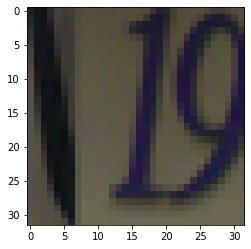

In [16]:
from matplotlib.pyplot import imshow

X = train["X"]
y = train["y"]
example = 0
assert(example < y.shape[0])

print("Digital Label", y[example][0])
imshow(X[:,:,:,example])